In [1]:
import sys
sys.path.append("scripts")  # Add the path to the scripts folder
#import script_file_1

import h5py
import pickle
import os
import pandas as pd


In [ ]:
# create list of file_paths to loop over and extract data from 
sess_dir = 'C:/code/SMTB_2023/imaging/data/5546'

In [ ]:
file_path = 'C:/code/SMTB_2023/imaging/data/5546/day0_corr08_pnr5_.hdf5'
with h5py.File(file_path, 'r') as hdf_file:
    print(hdf_file.keys())
    print(hdf_file['estimates'].keys())
    data = hdf_file['estimates']['C'][:]

file_path_write = file_path.replace('.hdf5', '.pkl')
with open(file_path_write, 'wb') as file:
    pickle.dump(data, file)

In [ ]:
# RUN TIMESTAMP_CONCAT_ALIGN.IPYNB

In [ ]:
# now load both pkls and combine them into one 
behavior_output_path = sess_dir + '/forCaiman.pkl'
with open(behavior_output_path, 'rb') as file:
    cv, boris1 = pickle.load(file)
with open(file_path_write, 'rb') as file:
    C_array = pickle.load(file)

    
file_path_total = file_path_write.replace('.pkl', 'total.pkl')
with open(file_path_total, 'wb') as f:
    pickle.dump([C_array, cv, boris1], f)

In [19]:
##LOAD DATA


files_to_analyze = ['C:/code/SMTB_2023/imaging/data/5546/day0_corr08_pnr5_total.pkl']
with open(files_to_analyze[0], 'rb') as file:
    C_array, cv, boris1 = pickle.load(file)


In [ ]:
print(C_array.shape)

In [ ]:
print(cv.shape)

In [ ]:
print(type(boris1))

In [ ]:
boris1.

In [ ]:
boris1['Behavior'].unique()

In [ ]:
print(boris1.scopeFrameEnd.max())

In [ ]:
107204 / 53613

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def visualize_2D_matrix_with_shading(matrix, behavior_df, behavior_name, default_vmax=1.0):
    def update_plot(colormap, vmin, vmax):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.imshow(matrix, cmap=colormap, vmin=vmin, vmax=vmax, aspect='auto')
        plt.colorbar()
        plt.title("One-Photon Calcium Imaging 2D Matrix")
        plt.xlabel("Time")
        plt.ylabel("Neurons")
        
        # Get 'scopeFrameStart' and 'scopeFrameEnd' values for the specified behavior name
        behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
        start_frames = behavior_data['scopeFrameStart'].values
        end_frames = behavior_data['scopeFrameEnd'].values
        
        # Plot shaded regions for 'scopeFrameStart' and 'scopeFrameEnd'
        for start_frame, end_frame in zip(start_frames, end_frames):
            plt.axvspan(start_frame, end_frame, color='lightblue', alpha=0.6)
        
        plt.show()

    # Define interactive widgets (same as before)
    colormap_selector = widgets.Dropdown(
        options=['viridis', 'plasma', 'inferno', 'magma', 'cividis'],
        value='viridis',
        description='Colormap:',
    )

    vmin_slider = widgets.FloatSlider(
        value=np.min(matrix),
        min=np.min(matrix),
        max=np.max(matrix),
        step=0.1,
        description='Min Value:',
    )
    
    vmax_slider = widgets.FloatSlider(
        value=default_vmax,
        min=np.min(matrix),
        max=np.max(matrix),
        step=0.1,
        description='Max Value:',
    )

    # Create the interactive plot (same as before)
    interactive_plot = widgets.interactive(
        update_plot,
        colormap=colormap_selector,
        vmin=vmin_slider,
        vmax=vmax_slider,  # Using the checkbox value directly for vmax_auto
    )

    display(interactive_plot)


In [25]:
%matplotlib notebook


In [26]:
default_vmax = 1.0
visualize_2D_matrix_with_shading(C_array, boris1, 'mount', default_vmax=10)

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

In [ ]:
def get_transient_timestamps(
    neural_data, thresh_type="eps", do_zscore=True, std_thresh=5
):
    """
    Converts an array of continuous time series (e.g., traces or S)
    into lists of timestamps where activity exceeds some threshold.

    :parameters
    ---
    neural_data: (neuron, time) array
        Neural time series, (e.g., C or S).

    std_thresh: float
        Number of standard deviations above the mean to define threshold.

    :returns
    ---
    event_times: list of length neuron
        Each entry in the list contains the timestamps of a neuron's
        activity.

    event_mags: list of length neuron
        Event magnitudes.

    """
    # Compute thresholds for each neuron.
    neural_data = np.asarray(neural_data, dtype=np.float32)
    if thresh_type == "eps":
        thresh = np.repeat(np.finfo(np.float32).eps, neural_data.shape[0])
    else:
        if do_zscore:
            stds = np.std(neural_data, axis=1)
            #print(stds.shape)
            means = np.mean(neural_data, axis=1)
            thresh = means + std_thresh * stds
        else:
            thresh = np.repeat(std_thresh, neural_data.shape[0])

    # Get event times and magnitudes.
    bool_arr = neural_data > np.tile(thresh, [neural_data.shape[1], 1]).T

    event_times = [np.where(neuron > t)[0] for neuron, t in zip(neural_data, thresh)]

    event_mags = [neuron[neuron > t] for neuron, t in zip(neural_data, thresh)]

    return event_times, event_mags, bool_arr

In [ ]:
## Convert to boolean

events, magnitudes, bool_arr = get_transient_timestamps(C_array, thresh_type='zscore', std_thresh=5)

In [ ]:
print(std.shape)

In [ ]:
bool_arr

In [ ]:
visualize_2D_matrix_with_shading(bool_arr, boris1, '', default_vmax=1)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_time_locked_responses(matrix, behavior_df, behavior_name, window_before_sec=1, window_after_sec=1, frame_rate=15):
    # Convert time windows from seconds to frames
    window_before_frames = int(window_before_sec * frame_rate)
    window_after_frames = int(window_after_sec * frame_rate)

    # Get the behavior data for the specified behavior name
    behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
    behavior_start_frame = behavior_data['scopeFrameStart'].values[0]
    behavior_end_frame = behavior_data['scopeFrameEnd'].values[0]

    # Calculate the view start and view end based on the specified window_before_frames and window_after_frames
    view_start = behavior_start_frame - window_before_frames
    view_end = behavior_end_frame + window_after_frames

    clear_output(wait=True)
    plt.close()  # Close the previous figure
    plt.figure(figsize=(12, 6))

    # Calculate the time points relative to the behavior event in seconds
    time_points = np.linspace(-window_before_sec, window_after_sec, view_end - view_start + 1)

    # Extract the time-locked responses for all cells
    time_locked_responses = matrix[:, view_start:view_end + 1]

    # Calculate mean and standard deviation across all cells for each time point
    mean_response = np.median(time_locked_responses, axis=0)
    std_response = np.std(time_locked_responses, axis=0)

    # Plot mean and standard deviation
    plt.plot(time_points, mean_response, color='b', lw=2, label='Mean')
    plt.fill_between(time_points, mean_response - std_response, mean_response + std_response,
                     color='b', alpha=0.3, label='Standard Deviation')

    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Vertical line at behavior event

    plt.title(f"Time-Locked Responses to Behavior: {behavior_name}")
    plt.xlabel("Time Relative to Behavior Event (seconds)")
    plt.ylabel("Calcium DF/F")
    plt.grid(True)
    plt.legend()
    plt.show()

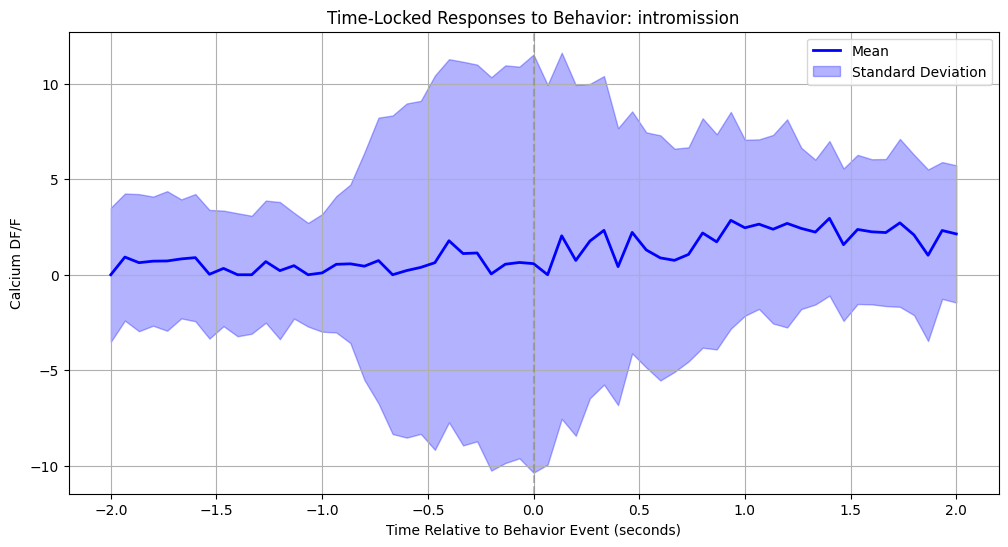

In [16]:
frame_rate = 15
window_before_sec = 2
window_after_sec = 2
plot_time_locked_responses(C_array, boris1, 'intromission',window_before_sec, window_after_sec)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button
from IPython.display import display, clear_output

def plot_time_locked_responses(matrix, behavior_df, behavior_name, window_before_sec=1, window_after_sec=1, frame_rate=15):
    # Convert time windows from seconds to frames
    window_before_frames = int(window_before_sec * frame_rate)
    window_after_frames = int(window_after_sec * frame_rate)

    # Get the behavior data for the specified behavior name
    behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
    behavior_start_frame = behavior_data['scopeFrameStart'].values[0]
    behavior_end_frame = behavior_data['scopeFrameEnd'].values[0]

    # Calculate the view start and view end based on the specified window_before_frames and window_after_frames
    view_start = behavior_start_frame - window_before_frames
    view_end = behavior_end_frame + window_after_frames

    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate the time points relative to the behavior event in seconds
    time_points = np.linspace(-window_before_sec, window_after_sec, view_end - view_start + 1)

    # Extract the time-locked responses for all cells
    time_locked_responses = matrix[:, view_start:view_end + 1]

    # Calculate mean and standard deviation across all cells for each time point
    mean_response = np.mean(time_locked_responses, axis=1)
    std_response = np.std(time_locked_responses, axis=1)

    # Plot mean and standard deviation
    ax.plot(len(time_locked_responses), mean_response, color='b', lw=2, label='Mean')
    ax.fill_between(time_points, mean_response - std_response, mean_response + std_response,
                    color='b', alpha=0.3, label='Standard Deviation')

    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Vertical line at behavior event

    ax.set_title(f"Time-Locked Responses to Behavior: {behavior_name}")
    ax.set_xlabel("Time Relative to Behavior Event (seconds)")
    ax.set_ylabel("Calcium DF/F")
    ax.grid(True)
    ax.legend()

    # Interactive buttons to navigate through the rows
    prev_button = widgets.Button(description='Previous')
    next_button = widgets.Button(description='Next')

    current_row = 0  # Start with the first row

    def on_prev_button_clicked(b):
        nonlocal current_row
        current_row = max(0, current_row - 1)  # Ensure we don't go below 0
        update_plot()

    def on_next_button_clicked(b):
        nonlocal current_row
        current_row = min(matrix.shape[0] - 1, current_row + 1)  # Ensure we don't exceed the number of rows
        update_plot()

    def update_plot():
        # Clear the previous plot
        ax.clear()

        # Plot mean and standard deviation for the current row
        ax.plot(len(current_row), current_row, color='b', lw=2, label='Mean')
        #ax.fill_between(time_points, mean_response - std_response, mean_response + std_response,
        #                color='b', alpha=0.3, label='Standard Deviation')

        #ax.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Vertical line at behavior event

        ax.set_title(f"Time-Locked Responses to Behavior: {behavior_name}, Row: {current_row}")
        ax.set_xlabel("Time Relative to Behavior Event (seconds)")
        ax.set_ylabel("Calcium DF/F")
        ax.grid(True)
        ax.legend()
        plt.show()

    prev_button.on_click(on_prev_button_clicked)
    next_button.on_click(on_next_button_clicked)

    # Display the buttons
    display(widgets.HBox([prev_button, next_button]))

    update_plot()

In [ ]:
pip show ipywidgets

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def plot_neuron_response(matrix, behavior_df, behavior_name, frames_before=30, frames_after=30):
    # Filter the DataFrame based on the specified behavior name
    behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
    
    if behavior_data.empty:
        print(f"No data found for behavior '{behavior_name}'.")
        return

    # Extract the start and end frames for the specified behavior
    start_frames = behavior_data['scopeFrameStart'].values

    # Calculate the time points relative to the behavior event
    time_points = np.arange(-frames_before, frames_after + 1)

    # Calculate the time-locked responses for each neuron
    time_locked_responses = []
    for start_frame in start_frames:
        response_start = max(start_frame - frames_before, 0)
        response_end = min(start_frame + frames_after + 1, matrix.shape[1])
        response = matrix[:, response_start:response_end]
        response_padded = np.pad(response, ((0, 0), (max(0, frames_before - (start_frame - response_start)),
                                                 max(0, frames_after - (response_end - start_frame)))), 
                                 mode='constant', constant_values=np.nan)
        time_locked_responses.append(response_padded)

    if not time_locked_responses:
        print(f"No valid time-locked responses found for behavior '{behavior_name}'.")
        return

    # Calculate mean and standard deviation across all trials for each neuron
    mean_response = np.nanmean(time_locked_responses, axis=0)
    std_response = np.nanstd(time_locked_responses, axis=0)

    # Create an interactive plot
    fig, ax = plt.subplots(figsize=(10, 6))

   # Initialize the plot with the first neuron
    neuron_idx = 0
    line_mean, = ax.plot(time_points, mean_response[neuron_idx], label=f'Neuron {neuron_idx + 1}')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Vertical line at behavior onset
    ax.set_title(f"Mean and Standard Deviation of Neuron Responses to Behavior: '{behavior_name}'")
    ax.set_xlabel("Time Relative to Behavior Onset (Frames)")
    ax.set_ylabel("Neuron Response")
    ax.legend()
    ax.grid(True)

    def update_plot(neuron_idx):
        ax.clear()  # Clear the existing plot before adding new data
        line_mean, = ax.plot(time_points, mean_response[neuron_idx], label=f'Neuron {neuron_idx + 1}')
        ax.fill_between(time_points, mean_response[neuron_idx] - std_response[neuron_idx],
                        mean_response[neuron_idx] + std_response[neuron_idx], alpha=0.3)
        ax.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Vertical line at behavior onset
        ax.set_title(f"Mean and Standard Deviation of Neuron Responses to Behavior: '{behavior_name}'")
        ax.set_xlabel("Time Relative to Behavior Onset (Frames)")
        ax.set_ylabel("Neuron Response")
        ax.legend()
        ax.grid(True)
        plt.draw()

    def update_legend(neuron_idx):
        handles, labels = ax.get_legend_handles_labels()
        label = f'Neuron {neuron_idx + 1}'
        if label not in labels:
            handles.append(line_mean)
            labels.append(label)
        ax.legend(handles, labels)

    # Function to handle the key press event and update the neuron index
    def on_key(event):
        nonlocal neuron_idx
        if event.key == 'right':
            neuron_idx = min(neuron_idx + 1, matrix.shape[0] - 1)
        elif event.key == 'left':
            neuron_idx = max(neuron_idx - 1, 0)
        update_plot(neuron_idx)

    # Connect the update_plot function to the key press event
    fig.canvas.mpl_connect('key_press_event', on_key)

    plt.show()

<IPython.core.display.Javascript object>


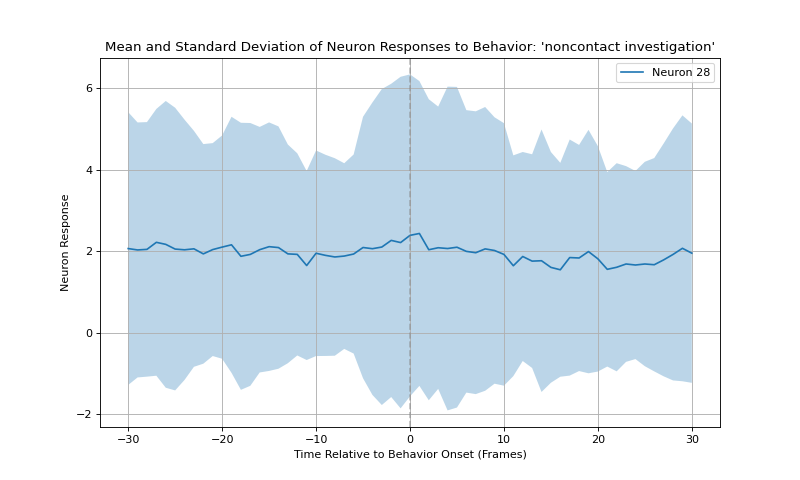

In [67]:
%matplotlib notebook
plot_neuron_response(C_array, boris1, 'noncontact investigation')


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_one_row_with_shading(matrix_row, behavior_df, behavior_name):
    # Filter the behavior DataFrame for the specified behavior name
    behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
    start_frames = behavior_data['scopeFrameStart'].values
    end_frames = behavior_data['scopeFrameEnd'].values

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(np.arange(len(matrix_row)), matrix_row, color='b', lw=2, label='Signal')

    # Add shading for the specified behavior intervals
    for start_frame, end_frame in zip(start_frames, end_frames):
        ax.axvspan(start_frame, end_frame, alpha=0.3, color='yellow', label=behavior_name)

    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)  # Horizontal line at y=0

    ax.set_title("One-Row Plot with Shading")
    ax.set_xlabel("Time (in 10 min intervals)")
    ax.set_ylabel("Signal")
    ax.grid(True)
    # Set x-axis ticks at seconds intervals

    seconds_tick_interval = 9000  # Set the interval for seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=seconds_tick_interval))
    ax.set_xticklabels([0, 0, 10, 20, 30, 40, 50, 60])
    
    #ax.legend()
    plt.show()

In [ ]:
%matplotlib notebook

C:\Users\ephys\AppData\Local\Temp\ipykernel_16096\3523320053.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0, 10, 20, 30, 40, 50, 60])


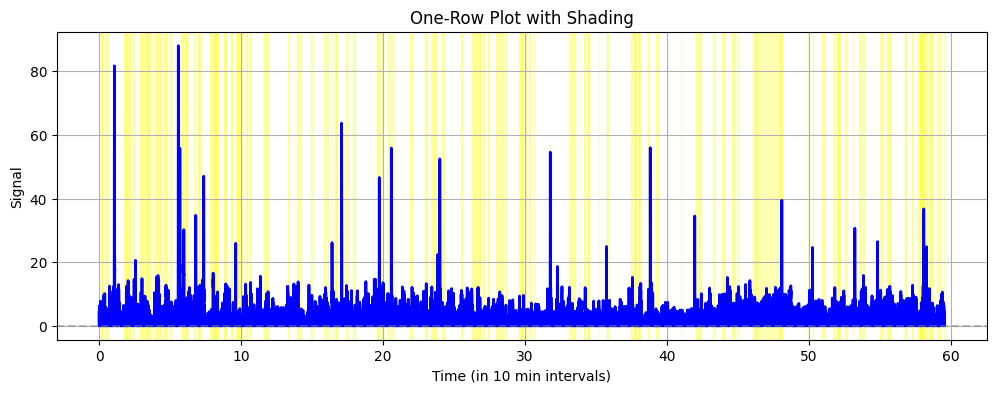

In [24]:
row_to_plot = 3
plot_one_row_with_shading(C_array[row_to_plot,:], boris1, 'noncontact investigation')

In [ ]:
import pandas as pd
import os
import re
import pdb #for debugging
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import auc
import pickle
import holoviews as hv
import numpy as np
import xarray as xr
import random

%load_ext autoreload
%autoreload 2


# ideally loop through multiple directories, load variables into single object per animal,
# and then have core functions to loop the objects through, with a plotter that
# pulls the outputs together 


day0 = "C://miniscopeData/5546/2022_12_15/13_56_20_record/12152022_cohabitation_5546"
day1 = "C://miniscopeData/5546/2022_12_16/14_36_12/121622_cohousing_5546"
day2 = "C://miniscopeData/5546/2022_12_17/12_48_22"
partner="Left"
novel="Right"
runPartner1OrNovel0 = 0

day14 = "C://miniscopeData/5546/2023_01_01/13_17_27/01012023_PPTnodrug"
partnerDay14="Right"
novelDay14="Left"


mainDir = day0
mainDirName = 'day0'

loadDir = os.path.join(mainDir + '/alignerOutput')


generalOutDir = "C://miniscopeData/5546"
writeOutDir = os.path.join(generalOutDir + '/analysesOutput')
isExist = os.path.exists(writeOutDir)
if not isExist:
    os.makedirs(writeOutDir)



with open(os.path.join(loadDir + '/minianOut.pkl'), 'rb') as f:
    cellsKept, cellsKeptSpikes, cv,boris1 = pickle.load(f)
    
#cellsKept, cellsKeptSpikes, cv, boris1


In [ ]:
#scratch cell, to look at downsampling of Minian, to make sure indices are appropriate
#temporal downsampling by 2 on Minian, so this should also be 2
#also transposes for corr matrix and PCA cells

columnNames = cellsKept.columns
numMinianFrames = max(columnNames)
numMinianDownsample = cellsKept.shape[1]

downsampleFactor = numMinianFrames / numMinianDownsample
print(downsampleFactor)

dsFactorUsed = 2

#print(numMinianFrames)

cellsKept.shape[0]
cellsTransposed = cellsKept.transpose()


#print(cellsKept.shape[1])
#cellsKept.iloc[(cellsKept['frame']-32).abs().argsort()[:1]]

In [ ]:
cellsKept

In [ ]:
#CORR MATRIX ACROSS SESSION

import seaborn as sns 
#print(cellsTransposed)
matrix = cellsTransposed.corr()
mask_ut = np.triu(np.ones(matrix.shape)).astype(bool)
fig = plt.figure()
hmap = sns.heatmap(matrix,mask=mask_ut,vmin=-1,vmax=1,cmap="Spectral")

fileName = mainDirName + 'overallCorrMatrix.png'
saveFolder = os.path.join(writeOutDir,'corrMatrix/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName
fig.savefig(saveName)

#print(matrix)
#plt.matshow(matrix)
#plt.show()

In [ ]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

cellsKept = z_score(cellsKept)

print(cellsKept.ndim)

In [ ]:
#PCA ACROSS SESSION

#pip install pca

from pca import pca
import numpy as np
from sklearn.preprocessing import StandardScaler
  
    
def center(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=False)
    Xc = ss.fit_transform(X.T).T
    return Xc


#cellsKeptCentered = center(cellsTransposed)
#cellsKeptCenteredTransposed = cellsKeptCentered.transpose()



model = pca(n_components=0.99, normalize=True)
results = model.fit_transform(cellsTransposed)
fig,ax = model.plot()

# Make scatterplot
#model.scatter()

# Gradient over the samples. High dense areas will be more colourful.
#model.scatter(gradient='#FFFFFF')

# Include the outlier detection
#model.scatter(SPE=True)

# Include the outlier detection
#model.scatter(hotellingt2=True)

# Look at different PCs: 1st PC=1  vs PC=3
#model.scatter(PC=[0, 2])

#fileName = mainDirName + 'overallPCA.png'
#saveFolder = os.path.join(writeOutDir,'PCA/')

#isExist = os.path.exists(saveFolder)
#if not isExist:
#    os.makedirs(saveFolder)
    
#saveName = saveFolder + fileName
#fig.savefig(saveName)

In [ ]:
def runPCA(matrixIn,directory):
    model = pca(n_components=0.95)
    results = model.fit_transform(matrixIn)
    fig,ax = model.plot()
    fig.savefig(directory)


In [ ]:
boris1.Behavior
behaviorUniques = list(set([car for car in boris1.Behavior]))
behaviorUniques





## optional cell for warping behavior and neural data to accomodate equal event totals

# modify boris1. 





In [ ]:
#pulling out events and corresponding data 

behaviorOfInterestCleversys = 'Social Approach' #cleversys-defined social contact
#behaviorOfInterestCleversys = '1 to 2' #cleversys-defined social approach 1 to 2

behaviorOfInterestBoris = 'contact investigation' #boris-defined contact investigation
#behaviorOfInterestBoris = '' #boris-defined contact investigation


Boris1OrCleversys0 = 1
plotCells1OrSpikes0 = 0

if plotCells1OrSpikes0 == 1:
    dataUsed = cellsKept
else:
    dataUsed = cellsKeptSpikes


socialCv = cv[cv.EventType.str.contains(behaviorOfInterestCleversys)]
#socialCv = socialCv[(socialCv.LengthinSec > 1)] #limit to >1sec bouts
socialCv = socialCv.tail(-1)
#print(socialCv)

upsampleNovel = 0

boris1.rename(columns={'Behavioral category': 'BehavioralCategory'},inplace=True)
socialCvBoris = boris1[boris1.Behavior.str.contains(behaviorOfInterestBoris)]
socialCvBoris = socialCvBoris[socialCvBoris.Behavior.str.contains(behaviorOfInterestBoris)]
#socialCvBoris = socialCvBoris[socialCvBoris.BehavioralCategory.str.contains('Affiliative')]


#socialCvBoris = socialCvBoris[(socialCvBoris['Duration (s)'] > 1)]
if mainDir == day2:
    socialCvBorisNovel = socialCvBoris[socialCvBoris.Subject.str.contains(novel)]
    socialCvBorisPartner = socialCvBoris[socialCvBoris.Subject.str.contains(partner)]
    if runPartner1OrNovel0==1:
        socialCvBoris = socialCvBorisPartner
    elif runPartner1OrNovel0==0:
        socialCvBoris = socialCvBorisNovel
        
    upsampleNovel = 1 
    #socialCvBoris = socialCvBoris[socialCvBoris.Behavior.str.contains('noncontact')]
elif mainDir == day14:
    socialCvBoris = socialCvBoris[socialCvBoris.Subject.str.contains(novel)]
socialCvBoris = socialCvBoris.tail(-1)
if Boris1OrCleversys0==1:
    socialCv = socialCvBoris
    behaviorOfInterest = behaviorOfInterestBoris

numBeforeEvent = 20
numAfterEvent = 30
numTotal = numBeforeEvent + numAfterEvent
socialContactC = np.zeros([dataUsed.shape[0],numTotal,socialCv.shape[0]])
print(socialContactC.shape)


for ev in range(socialCv.shape[0]):
    if Boris1OrCleversys0 == 0:
        scopeFrameStart = socialCv.iloc[ev,9]
    else: 
        scopeFrameStart = socialCv.iloc[ev,18]
        
    minianFrameStart = scopeFrameStart/dsFactorUsed
    minianFrameStart = round(minianFrameStart)
    if Boris1OrCleversys0 == 0:
        scopeFrameEnd = socialCv.iloc[ev,10]
    else:
        scopeFrameEnd = socialCv.iloc[ev,19]
    minianFrameEnd = scopeFrameEnd/dsFactorUsed
    minianFrameEnd = round(minianFrameEnd)
    #try: #to account for events happening too close to end
    socialContactC[:,0:numBeforeEvent-1,ev] = dataUsed.iloc[:,minianFrameStart-numBeforeEvent:minianFrameStart-1]
    socialContactC[:,numBeforeEvent-1:numTotal,ev] = dataUsed.iloc[:,minianFrameStart:minianFrameStart+numAfterEvent+1] 
    #except:
        #pass
    
    
#socialContactC = np.nanmean(socialContactC,axis=2) #nanmean across bouts
#print(socialCvBoris)
#socialCvBoris.sum(' Duration (s)')



total = socialCvBoris['Duration (s)'].sum()
print(total)

#socialCvBoris


In [ ]:
import Assemblies_MEK
dataUsedDf = dataUsed.to_numpy()
np.shape(dataUsedDf)

In [ ]:
import importlib
importlib.reload(Assemblies_MEK)
assembly_dict, fig, axs = Assemblies_MEK.find_assemblies(dataUsedDf,method='ica',nullhyp='mp',n_shuffles=1000,percentile=99,tracywidow=False,
                              compute_activity=True, use_bool=False, plot=True)
#assembly_dict has patterns, significance, z_data, orig_data, and activations

   
fileName = mainDirName + 'assemblies_spikes.png'

saveFolder = os.path.join(writeOutDir,'assemblies/')

print(len(assembly_dict['activations']))

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName

#fig.savefig(saveName)

In [ ]:
patterns = assembly_dict['patterns']
activations = assembly_dict['activations']
sorted_spiking = assembly_dict['sorted_spiking']
sorted_colors = assembly_dict['sorted_colors']

print(activations.shape)


fig,axs = Assemblies_MEK.plot_assemblies_select(activations, sorted_spiking, colors=sorted_colors)


fileName = mainDirName + 'assemblies_spikes_example.png'

saveFolder = os.path.join(writeOutDir,'assemblies/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName


#with open(os.path.join(saveFolder + '\_5546_day0.pkl'), 'wb') as f:
    #pickle.dump([assembly_dict], f)

In [ ]:
# 1) try warping novel events using nearest neighbor to equalize the num of frames for each event type
# 2) using total novel time, subsample partner time & remove other frames

import statistics 

totalSession = boris1['Duration (s)'].sum()
#print(totalSession)

totalPartner = socialCvBorisPartner['Duration (s)'].sum()
totalNovel = socialCvBorisNovel['Duration (s)'].sum()
novelTimeToAddTotal = (totalPartner-totalNovel)
#print(middlePoint)

# divide amount of necessary added time by # events to add that time to
#novelTimeToAdd = middlePoint - totalNovel
#partnerTimeToSubtract = totalPartner - middlePoint

#print(len(socialCvBorisPartner))
#print(len(socialCvBorisNovel))
novelTimeToAdd = novelTimeToAddTotal / len(socialCvBorisNovel)
#partnerTimeToSubtract = partnerTimeToSubtract / len(socialCvBorisPartner)
#print(novelTimeToAdd)
#print(partnerTimeToSubtract)


# find avg conversion between behavior frame #s and minian frame #s. use that 
differenceFrameNums = socialCvBorisNovel.iloc[:,17] - socialCvBorisNovel.iloc[:,16]
differenceScopeNums = socialCvBorisNovel.iloc[:,19] - socialCvBorisNovel.iloc[:,18]
avgConversion = np.mean(differenceScopeNums / differenceFrameNums)


#bug - newMinianLength changes with every event, so cant be set in stone here
#but if I write it back into dataUsed, then the indices for that change..
newCell = np.zeros((len(tempData),dataUsed.shape[1]+(novelTimeToAddTotal*avgConversion),socialCvBorisNovel.shape[0]))
                   
#print(socialCvBorisNovel.shape[0])
#print(newMinianLength)

for ev in [0]:#range(socialCvBorisNovel.shape[0]):

    # pull out cam and scope frame indices
    camFrameStart = socialCvBorisNovel.iloc[ev,16]
    camFrameStop = socialCvBorisNovel.iloc[ev,17]
    scopeFrameStart = socialCvBorisNovel.iloc[ev,18]
    scopeFrameEnd = socialCvBorisNovel.iloc[ev,19]

    #display(socialCvBorisNovel.iloc[0:5,:])

    #convert seconds into frames to add
    framesToAdd = novelTimeToAdd * 50
    # add new behavior frames. these will become 1s downstream
    newEnd = (round(camFrameStop+framesToAdd))
    socialCvBorisNovel.iloc[ev,17] = newEnd
        # adjust the rest of the frames to account for this change
    socialCvBorisNovel.iloc[ev+1:-1,16] = socialCvBorisNovel.iloc[ev+1:-1,16] + int(framesToAdd)
    socialCvBorisNovel.iloc[ev+1:-1,17] = socialCvBorisNovel.iloc[ev+1:-1,17] + int(framesToAdd)

    # now go into neural data and interpolate to warp equivalent amount of neural data

    # find new minianFrameStart and minianFrameEnd
    # go into dataUsed and interpolate it, making dataUsed larger
    scopeFramesToAdd = int(framesToAdd * avgConversion)
    newScopeFrameEnd = scopeFrameEnd + scopeFramesToAdd
    socialCvBorisNovel.iloc[ev,19] = newScopeFrameEnd

    # adjust the rest of the frames to account for this change
    # when indexed in the future, it will ultimately point to a modified dataUsed that has new frames
    socialCvBorisNovel.iloc[ev+1:-1,18] = socialCvBorisNovel.iloc[ev+1:-1,18] + int(scopeFramesToAdd)
    socialCvBorisNovel.iloc[ev+1:-1,19] = socialCvBorisNovel.iloc[ev+1:-1,19] + int(scopeFramesToAdd)

    # get the typical minian frame indices
    minianFrameStart = scopeFrameStart/dsFactorUsed
    minianFrameStart = round(minianFrameStart)
    minianFrameEnd = scopeFrameEnd/dsFactorUsed
    minianFrameEnd = round(minianFrameEnd)


    # get new minian frame end index, and new length of data
    newMinianFrameEnd = round(newScopeFrameEnd / dsFactorUsed)
    newMinianLength = newMinianFrameEnd - minianFrameStart
    existingMinianLength = minianFrameEnd - minianFrameStart


    print(newMinianLength)
    print(existingMinianLength)

    # pull out the existing data
    tempData = dataUsed.iloc[:,minianFrameStart:minianFrameEnd]


    #Initialize new numpy matrix for cells with new length of data
    newCell = np.zeros((len(tempData),newMinianLength))

    # loop through cells
    for cell in [0]:#[0]:#range(len(dataUsed)):
        #print(cell)
        tempDataCell = tempData.iloc[cell,:] 


        # to determine how many times to repeat Minian values 
        multiplyFactor = (round(newMinianLength/existingMinianLength))
        #print(multiplyFactor)

    
        tempDataCell = tempDataCell.to_numpy()
        tempDataCell = np.repeat(tempDataCell,multiplyFactor+1,axis=0)

        #print(newMinianLength)

        #now, take out the # of frames that we overshot by
        #shitty way to do it
        change = (len(tempDataCell) - newMinianLength)
        randDelete = random.sample(range(0,len(tempDataCell)),change)
        tempDataCell = np.delete(tempDataCell,randDelete)
        #print(len(tempDataCell))

        # insert into array
        newCell[cell,:] = tempDataCell

        #tempDataCell  = pd.DataFrame(tempDataCell)
        #tempData.iloc[cell,:] = tempDataCell
        #dataWriteIn = newCell[cell,0:existingMinianLength]
        
        
        #len(dataWriteIn.columns)
        
        #dataWriteIn = newCell.reshape((existingMinianLength,))
        #dataWriteIn = pd.DataFrame(newCell[cell,0:existingMinianLength])
        #dataWriteIn = pd.DataFrame(dataWriteIn)
        #dataWriteIn = dataWriteIn.reshape((existingMinianLength,))
    dataWriteIn = newCell[:,0:existingMinianLength]
    print(dataWriteIn.shape)
    dataUsed.iloc[:,minianFrameStart:minianFrameEnd] = dataWriteIn
    
    print(dataUsed.shape)
        
    # now for anything beyond existing MinianLength, need to expand the # of columns
    numRemaining = newMinianLength - existingMinianLength
    remainingData = newCell[:,-numRemaining:]
    numSamples = (remainingData.shape[0])
    #print(minianFrameEnd+1)
    #print(minianFrameEnd+1+numSamples)
    #print([minianFrameEnd+1:minianFrameEnd+1+numSamples])
    #dataUsed.insert(minianFrameEnd+1:minianFrameEnd+1+remainingData.shape,[],remainingData)
    #dataUsed.insert[cell,minianFrameEnd+1,'columns'] = remainingData    
    #display(pd.DataFrame(remainingData))
    
    
    
    print(remainingData.shape)
    print(dataUsed.shape)
    
    
    remainingData = pd.DataFrame(remainingData)
    unitIdNames = (dataUsed.index)
    remainingData.index = unitIdNames
    
    dataUsed = dataUsed.join(remainingData,rsuffix='_')





In [ ]:
#display(dataUsed)
print(remainingData.shape)
print(dataWriteIn.shape)
print(unitIdNames)

#dataUsed2 = dataUsed.join(remainingData,rsuffix='_')
#print(dataUsed2.shape)
display(dataUsed)

## BEHAVIOR SPECIFIC PCA
socialContactC_acrossCells = np.nanmean(socialContactC,axis=2) #nanmean across bouts
socialContactC_acrossCells = socialContactC_acrossCells.transpose()
model = pca(n_components=0.95)
results = model.fit_transform(socialContactC_acrossCells)
fig,ax = model.plot()

fileName = mainDirName + 'BehaviorPCA.png'
if mainDir == day2:
    fileName = mainDirName + 'NovelBehaviorPCA.png'
elif mainDir == day14:
    fileName = mainDirName + 'PartnerBehaviorPCA.png'
    

saveFolder = os.path.join(writeOutDir,'PCA/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName
fig.savefig(saveName)

#fig.savefig(directory)

In [ ]:
#function for running AUC shuffles
def auROCshuffle(cellActivity):
    cellActivityZScore = stats.zscore(cellActivity)

    # initialize TPR and FPR for each of the 100 steps
    TPR_cell = [0] * 100
    FPR_cell = [0] * 100

    #max(cellActivityZScore)
    #min(cellActivityZScore)

    # define 100 steps of z-scored DF/F
    steps = np.linspace(min(cellActivityZScore),max(cellActivityZScore),num=100)

    for st in range(len(steps)):
        # iter through steps, calculate metrics, aggregate
        indices = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] >= steps[st]]
        indicesBelow = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] < steps[st]]
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for ind in range(len(indices)):
            behaviorPresence  = contactBinary[indices[ind]]
            if behaviorPresence==1:
                TP = TP + 1
            if behaviorPresence==0:
                FP = FP + 1
    
        for indBelow in range(len(indicesBelow)):
            behaviorPresence = contactBinary[indicesBelow[indBelow]]
            if behaviorPresence==1:
                FN = FN + 1
            if behaviorPresence==0:
                TN = TN + 1
        #try:
        TPR_cell[st] = TP / (TP + FN)
        #except:
            #sometimes TPR is dividing by 0 b/c at a given threshold, there were no true positives and no false negatives yet
            #TPR_cell[st] = 0
            #print(st)
            #print(ind)
        if doPRC==0:
            FPR_cell[st] = FP / (FP + TN)
        elif doPRC==1:
            FPR_cell[st] = TP / (TP + FP) #actually precision

    # plot AUCs on top of one another and write out AUC
    #plt.plot(FPR_cell,TPR_cell,'b')
    if doPRC==1:
        AUC_shuffles = auc(TPR_cell,FPR_cell)
    elif doPRC==0:
        AUC_shuffles = auc(FPR_cell,TPR_cell)
    
    return AUC_shuffles

In [ ]:
print(cellsKept.shape)
print(activations.shape)
cellsKept = pd.DataFrame(activations)

In [ ]:
runShuffle = 1
doPRC = 1
import nn_interpolate

#construct binary vector of behavior yes/no
contactBinary = [0] * numMinianDownsample

from collections import deque
from random import randint

# go through behaviors, find the minian frames they align to, and assign those as 1s
for ev in range(socialCv.shape[0]):
    if Boris1OrCleversys0 == 0:
        scopeFrameStart = socialCv.iloc[ev,9] #this is 
    else: 
        scopeFrameStart = socialCv.iloc[ev,18]
        
    minianFrameStart = scopeFrameStart/dsFactorUsed
    minianFrameStart = round(minianFrameStart)
    if Boris1OrCleversys0 == 0:
        scopeFrameEnd = socialCv.iloc[ev,10]
    else:
        scopeFrameEnd = socialCv.iloc[ev,19]
    minianFrameEnd = scopeFrameEnd/dsFactorUsed
    minianFrameEnd = round(minianFrameEnd)
    temp = np.tile(1,minianFrameEnd-minianFrameStart) #vector of 1s
    temp = np.ndarray.tolist(temp)
    contactBinary[minianFrameStart:minianFrameEnd] = temp #insert 1s into the binary vector


#count_1 = contactBinary.count(1)
if doPRC==0:
    fileName = mainDirName + 'auROC.png'
elif doPRC==1:
    fileName = mainDirName + 'PRC.png'


if mainDir == day2:
    if runPartner1OrNovel0==0:
        fileName = mainDirName + 'novel_PRC.png'
    elif runPartner1OrNovel0==1:
        fileName = mainDirName + 'partner_PRC.png' 
elif mainDir == day14:
    fileName = mainDirName + 'novel_PRC.png'
    

saveFolder = os.path.join(writeOutDir,'auROC/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName



# initialize AUC vector
AUC_cells = [0] * cellsKept.shape[0]

fig = plt.figure()

#if warp==1, I can change cellsKept into a numpy array that includes mods 

# iterate through cells
for cell in range(cellsKept.shape[0]):
    print(cell)
    cellNum = cell
    cellActivity = cellsKept.iloc[cellNum,:]
    cellActivity = cellActivity.tolist()
    #print(cellActivity)
    cellActivityZScore = stats.zscore(cellActivity)

    # initialize TPR and FPR for each of the 100 steps
    TPR_cell = [0] * 100
    FPR_cell = [0] * 100

    #max(cellActivityZScore)
    #min(cellActivityZScore)

    # define 100 steps of z-scored DF/F
    steps = np.linspace(min(cellActivityZScore),max(cellActivityZScore),num=100)

    for st in range(len(steps)):
        # iter through steps, calculate metrics, aggregate
        indices = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] >= steps[st]]
        indicesBelow = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] < steps[st]]
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for ind in range(len(indices)):
            behaviorPresence  = contactBinary[indices[ind]]
            if behaviorPresence==1:
                TP = TP + 1
            if behaviorPresence==0:
                FP = FP + 1
    
        for indBelow in range(len(indicesBelow)):
            behaviorPresence = contactBinary[indicesBelow[indBelow]]
            if behaviorPresence==1:
                FN = FN + 1
            if behaviorPresence==0:
                TN = TN + 1
                
                
        if doPRC==0:
            FPR_cell[st] = FP / (FP + TN)
        elif doPRC==1:
            FPR_cell[st] = TP / (TP + FP) #actually precision
        
        #try:
        TPR_cell[st] = TP / (TP + FN)
        #except:
            #need to figure out why a few cells are trying to divide by zero 
            #TPR_cell[st] = 0
            #import pdb; pdb.set_trace()
            #print(st)
            #print(ind)
        #print(TPR_cell[st])
        #print(FPR_cell[st])   
 

    # plot AUCs on top of one another and write out AUC
    if doPRC==1:
        AUC_cells[cell] = auc(TPR_cell,FPR_cell)
    elif doPRC==0:
        AUC_cells[cell] = auc(FPR_cell,TPR_cell)
        
        
    #AUC_cells[cell] = auc(FPR_cell,TPR_cell)
    
    if runShuffle==1:    
    
        AUC_shuffleAll = [0] * 100
        items = deque(cellActivity)
        for shuffle in range((100)):
            #print(shuffle)
            items.rotate(randint(0,len(cellActivityZScore)))
            shuffledCellActivity = list(items)
            AUC_shuffleAll[shuffle] = auROCshuffle(shuffledCellActivity)
            #print(AUC_shuffleAll[shuffle])
        shufflesNoZeros = [i for i in AUC_shuffleAll if i!= 0]
        if doPRC==0:
            if AUC_cells[cell] > np.percentile(shufflesNoZeros,97.5):
                plt.plot(FPR_cell,TPR_cell,'r')
            elif AUC_cells[cell] < np.percentile(shufflesNoZeros,2.5):
                plt.plot(FPR_cell,TPR_cell,'r')
            else:
                plt.plot(FPR_cell,TPR_cell,'b')
        elif doPRC==1:
            if AUC_cells[cell] > np.percentile(shufflesNoZeros,97.5):
                plt.plot(TPR_cell,FPR_cell,'r')
            elif AUC_cells[cell] < np.percentile(shufflesNoZeros,2.5):
                plt.plot(TPR_cell,FPR_cell,'r')
            else:
                plt.plot(TPR_cell,FPR_cell,'b')            
            
    elif runShuffle==0:
        
        if doPRC==0:
            plt.plot(FPR_cell,TPR_cell,'b')
        elif doPRC==1:
            plt.plot(TPR_cell,FPR_cell,'b')
        
        
if doPRC==1:
    plt.xlabel("Recall")
    plt.ylabel("Precision")
elif doPRC==0:
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
fig.savefig(saveName)
#need a shuffle procedure
    
#with open(writeOutDir, 'wb') as f:
    #pickle.dump([AUC_cells], f)


    
#temp = np.tile(1,minianFrameEnd-minianFrameStart)
#temp = np.ndarray.tolist(temp)
#temp
#ls = [type(item) for item in temp]
#print(ls)
#np.tile(1,minianFrameEnd-minianFrameStart)

In [ ]:
#shufflesNoZeros
AUC_cells[cell]

In [ ]:
st=0
# iter through steps, calculate metrics, aggregate
indices = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] >= steps[st]]
indicesBelow = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] < steps[st]]


TP = 0
FP = 0
TN = 0
FN = 0
        
for ind in range(len(indices)):
    behaviorPresence  = contactBinary[indices[ind]]
    if behaviorPresence==1:
        TP = TP + 1
    if behaviorPresence==0:
        FP = FP + 1
    
for indBelow in range(len(indicesBelow)):
    behaviorPresence = contactBinary[indicesBelow[indBelow]]
    if behaviorPresence==1:
        FN = FN + 1
    if behaviorPresence==0:
        TN = TN + 1
                
                
print(len(indices))
print(TP)
print(FN)

print(len(indicesBelow))

        

In [ ]:
from collections import deque
from random import randint

items=deque(cellActivity)
items.rotate(randint(0,len(cellActivity)))
shuffledCellActivity = list(items)

#print(cellActivity[0:5])

#items = deque(cellActivity)
#shuffleBy = randint(0,len(cellActivity))
#print(shuffleBy)
    
#items.rotate(shuffleBy)

#new = list(items)
#print(new[0:5])


#items.

#cellActivity.append(cellActivity.pop(0))

#print(cellActivity[0:5])

#print(cellActivityShuffled[0:5])

In [ ]:
AUC_shuffleAll = [0] * 100
items = deque(cellActivity)
for shuffle in range((100)):
    items.rotate(randint(0,len(cellActivity)))
    shuffledCellActivity = list(items)
    AUC_shuffleAll[shuffle] = auROCshuffle(shuffledCellActivity)
print(AUC_shuffleAll)
if AUC_cells[cell] > np.percentile(AUC_shuffleAll,97.5):
    #color it red
    elif AUC_cells[cell] < np.percentile(AUC_shuffleAll,2.5):
        # color it red
    else:
        # color it blue

In [ ]:
AUC_cells[cell] > np.percentile(AUC_shuffleAll,95)

In [ ]:
AUC_cells

In [ ]:
#print('computed AUC: {}'.format(auc(FPR_cell,TPR_cell)))

with open(os.path.join(writeOutDir + '\AUC_N.pkl'), 'wb') as f:
    pickle.dump([AUC_cells], f)
    
indexMaxAUC = [i for i in range(len(AUC_cells)) if AUC_cells[i] == max(AUC_cells)]
indexMaxAUC

ev


In [ ]:
openDir0 = os.path.join(mainDir0 + '/analysesOutput/AUC.pkl')
openDir1 = os.path.join(mainDir1 + '/analysesOutput/AUC.pkl')
openDir2 = os.path.join(mainDir2 + '/analysesOutput/AUC.pkl')

with open(openDir0, 'rb') as f:
    AUC_0 = pickle.load(f)
with open(openDir1, 'rb') as f:
    AUC_1 = pickle.load(f)    
with open(openDir2, 'rb') as f:
    AUC_2 = pickle.load(f)
    

In [ ]:
AUC_1

In [ ]:
stats.ttest_ind(AUC_0,AUC_1,axis=1)

#scipy.mean(AUC_0) - scipy.mean(AUC_1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


# initialize AUC vector
AUC_cells = [0] * cellsKept.shape[0]

# iterate through cells
for cell in range(cellsKept.shape[0]):
    cellNum = cell
    cellActivity = cellsKept.iloc[cellNum,:]
    cellActivity = cellActivity.tolist()
    cellActivityZScore = stats.zscore(cellActivity)
    
    fpr, tpr, thresholds = roc_curve(contactBinary, cellActivityZScore)
    
    


In [ ]:
#plotting by cell

figTotal,axTotal = plt.subplots(15,3,figsize=(10,10))
for cell in range(socialContactC.shape[0]):
    cellActivity = socialContactC[cell,:,:]
    socialContactMeans = np.nanmean(cellActivity,axis=1)
    socialContactSte = np.nanstd(cellActivity,axis=1)
    socialContactSte = socialContactSte / np.sqrt(cellActivity.shape[1])

    xval = np.arange(numTotal)
    plt.subplot(15,3,cell+1)
    plt.errorbar(xval,socialContactMeans,socialContactSte,linestyle='None')
    #plt.xlabel('Time relative to social contact (sec)')
    #plt.ylabel('DF/F')
    plt.xticks(np.arange(0,60,step=20),['-1.5', '0', '1.5', '3'])
    #ax.set_ylim(-0.05, 0.05)

In [ ]:
#plotting across cells
socialContactC_acrossCells = np.nanmean(socialContactC,axis=2) #nanmean across bouts

socialContactMeans = np.nanmedian(socialContactC_acrossCells,axis=0) #across cells
socialContactSte = np.nanstd(socialContactC_acrossCells,axis=0)
socialContactSte = socialContactSte / np.sqrt(socialContactC_acrossCells.shape[0])


xval = np.arange(numTotal)
plt.subplot()
plt.errorbar(xval,socialContactMeans,socialContactSte,linestyle='None')
plt.xlabel('Time relative to social contact (sec)')
plt.ylabel('DF/F')
plt.xticks(np.arange(0,60,step=20),['-1.5', '0', '1.5', '3'])

In [ ]:
cellNum = 35
cellActivity = socialContactC[cellNum,:,:]
# plot all 83 traces on one plot

xval = np.arange(numTotal)

np.shape(cellActivity)
for bout in range(cellActivity.shape[1]):
    plt.plot(xval,cellActivity[:,bout])
    
    plt.xticks(np.arange(0,60,step=20),['-1.5', '0', '1.5', '3'])
    plt.xlabel('Time relative to social approach (sec)')
    plt.ylabel('DF/F')